In [8]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy
from tempfile import TemporaryDirectory

In [10]:
# filename
temp_dir = TemporaryDirectory()
sim_ws = os.path.join(temp_dir.name)
sim_name = "IdealModel_PAT"
gwfname = "gwf_" + sim_name
gwtname = "gwt_" + sim_name

# units
length_units = "meters"
time_units = "days"

# Discretization
nper = 1
nlay = 1
nrow = 11
ncol = 11
delr = 1000
delc = 1000
top = 30
botm = -10
idomain = 1

# 设置渗流模型专门参数
# GWF
icelltype = 0 # 0 = 承压含水层； 1 = 潜水含水层；
k11 = 0.5    # 渗透系数

# 设置溶质运移模型专门参数:
# GWT
porosity = 0.2               # 孔隙度
Ldis = 50.0                    # 纵向弥散系数 Longitudinal dispersivity
Tdis = 10.0                    # 横向弥散系数   Transverse dispersivity
# 0              # 垂直弥散系数


# 时间离散化: Time discretization
perlen = 365*5   #模拟周期 5年
nstop =  5            #一个应力周期的时间步数
tsmult = 1.0   
tdis_ds = [(perlen,nstop, tsmult)]


#模型求解的一些参数:
# Solver parameters
nouter, ninner = 100, 300
hclose, rclose, relax = 1e-6, 1e-6, 1.0


#初始条件   Initial conditions
# Starting Heads 初始水头
strt = np.zeros((nlay, nrow, ncol), dtype=float)
#strt[:, :, 0] = 13.33

# Starting concentrations 初始浓度
sconc = 0.0

#边界条件:Boundary conditions

# wel_spd 井
qwell = 0.5
cwell = 100.0
#               (k, i, j),  flow,  conc
wel_spd = {0: [[(6, 7, 2), qwell, cwell]]}

# chd_spd 指定水头
chd_spd = []
for k in np.arange(nlay): # 东西两侧分别指定
    for i in np.arange(nrow):
        #               (l, r, c),          head, conc
        chd_spd.append([(k, i, 0), strt[k, i, 0], 0.0])
        chd_spd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
chd_spd = {0: chd_spd}

In [6]:
import numpy as np
nlay = 1
nrow = 11
ncol = 11
strt = np.zeros((nlay, nrow, ncol), dtype=float)
chd_spd = []
for k in np.arange(nlay):  # 东西两侧分别指定
    for i in np.arange(nrow):
        #               (l, r, c),          head, conc
        chd_spd.append([(k, i, 0), strt[k, i, 0], 0.0])
        chd_spd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], 0.0])
chd_spd = {0: chd_spd}
print(chd_spd)

{0: [[(0, 0, 0), 0.0, 0.0], [(0, 0, 10), 0.0, 0.0], [(0, 1, 0), 0.0, 0.0], [(0, 1, 10), 0.0, 0.0], [(0, 2, 0), 0.0, 0.0], [(0, 2, 10), 0.0, 0.0], [(0, 3, 0), 0.0, 0.0], [(0, 3, 10), 0.0, 0.0], [(0, 4, 0), 0.0, 0.0], [(0, 4, 10), 0.0, 0.0], [(0, 5, 0), 0.0, 0.0], [(0, 5, 10), 0.0, 0.0], [(0, 6, 0), 0.0, 0.0], [(0, 6, 10), 0.0, 0.0], [(0, 7, 0), 0.0, 0.0], [(0, 7, 10), 0.0, 0.0], [(0, 8, 0), 0.0, 0.0], [(0, 8, 10), 0.0, 0.0], [(0, 9, 0), 0.0, 0.0], [(0, 9, 10), 0.0, 0.0], [(0, 10, 0), 0.0, 0.0], [(0, 10, 10), 0.0, 0.0]]}


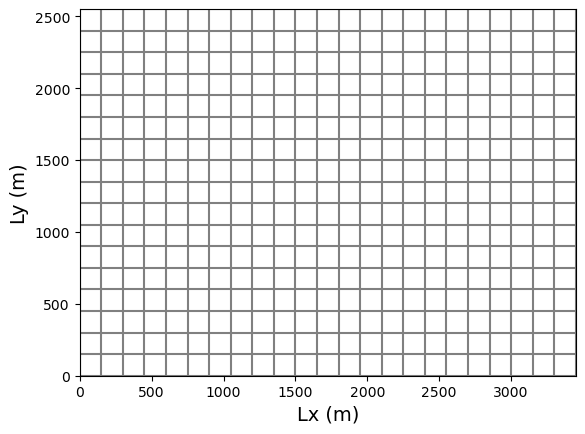

In [18]:
temp_dir = TemporaryDirectory()
sim_name = "IdealModel_PAT"
sim = flopy.mf6.MFSimulation(
    sim_name=sim_name,
    sim_ws=os.path.join(temp_dir.name),
    version="mf6",
    exe_name="mf6",
)

# 时间离散化
flopy.mf6.ModflowTdis(
    simulation=sim,  # simulation object
    nper=1,  # 应力周期 the number of stress periods
    # perioddata ([perlen, nstp, tsmult]),
    # perlen (double) is the length of a stress period.
    # nstp (integer) is the number of time steps in a stress period.
    perioddata=tdis_ds,  #
    # “unknown”, “seconds”, “minutes”, “hours”, “days”, or “years”. The default time unit is “unknown”.
    time_units="days",
)

# GWF
gwf = flopy.mf6.ModflowGwf(
    sim,
    modelname="gwf_" + sim_name,
    save_flows=True,
    model_nam_file="{}.nam".format(gwfname),
)

# 渗流模型求解参数
imsgwf = flopy.mf6.ModflowIms(
    simulation=sim,
    print_option="SUMMARY",
    #outer_dvclose=hclose,
    outer_maximum=100,
    #under_relaxation="NONE",
    inner_maximum=300,
    #inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="CG",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=1.0,  #松弛因子
    filename="{}.ims".format(gwfname),
)

# 每个ModflowGwf对象都需要与一个ModflowIms对象相关联。这是通过调用MFSimulation对象的“register_ims_package”方法来完成的。
# 该方法中的第一个参数是ModflowIms对象，而第二个参数是要与ModflowIms对象关联的模型的模型名称（字符串）的列表。
sim.register_ims_package(imsgwf, [gwf.name])
# 接下来，将包添加到每个模型中。添加的第一个包需要是空间离散化包，因为flopy使用空间离散化包包含的信息来帮助构建其他包。
# 离散化
flopy.mf6.ModflowGwfdis(
    model=gwf,
    # “FEET”, “METERS”, or “CENTIMETERS”. If not specified, the default is “UNKNOWN”.
    length_units=length_units,
    nlay=1,
    nrow=17,
    ncol=23,
    delr=150,  # 行方向上的列间距。
    delc=150,  # 列方向上的行间距。
    top=30,  # 顶部模型图层中每个单元的顶部高程。top elevation for each cell in the top model layer.
    botm=-10,  # 每个单元格的底部高程。
    #idomain=idomain,
    filename="{}.dis".format(gwfname),
)

# 含水层特性
flopy.mf6.ModflowGwfnpf(
    model=gwf,
    save_flows=False,
    #icelltype=0,
    # 对于用户想要指定水平导水率和垂直导水率的常见情况，则应将K指定为水平渗透系数
    # 将K33指定为垂直渗透系数并且不应指定K22和三个旋转角度。当需要更复杂的各向异性时，则K对应于K11导水率轴。
    icelltype = 1, # 0 = 承压含水层； 1 = 潜水含水层；
    k=0.5,  # 渗透系数
    #k33=k33,
    save_specific_discharge=True,
    filename="{}.npf".format(gwfname),
)
strt= np.zeros((1, 17, 23), dtype=float)
# 初始水头
flopy.mf6.ModflowGwfic(gwf, strt=strt, filename="{}.ic".format(gwfname))

# 指定水头边界
flopy.mf6.ModflowGwfchd(
    gwf,
    maxbound=len(chd_spd),
    stress_period_data=chd_spd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="CHD-1",
    filename="{}.chd".format(gwfname),
)

# 井边界
flopy.mf6.ModflowGwfwel(
    gwf,
    print_input=True,
    print_flows=True,
    stress_period_data=wel_spd,
    save_flows=False,
    auxiliary="CONCENTRATION",
    pname="WEL-1",
    filename="{}.wel".format(gwfname),
)

# 输出控制
flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord="{}.hds".format(gwfname),
    budget_filerecord="{}.bud".format(gwfname),
    headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

modelmap = flopy.plot.PlotMapView(model=gwf, layer=0)
grid = modelmap.plot_grid()
plt.xlabel("Lx (m)", fontsize=14)
plt.ylabel("Ly (m)", fontsize=14)
plt.show()

In [ ]:
# GWT
gwt = flopy.mf6.ModflowGwt(
    sim,
    modelname=gwtname,
    save_flows=True,
    model_nam_file="{}.nam".format(gwtname),
)

# 溶质运移模型求解参数
imsgwt = flopy.mf6.ModflowIms(
    sim,
    print_option="SUMMARY",
    outer_dvclose=hclose,
    outer_maximum=nouter,
    under_relaxation="NONE",
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=rclose,
    linear_acceleration="BICGSTAB",
    scaling_method="NONE",
    reordering_method="NONE",
    relaxation_factor=relax,
    filename="{}.ims".format(gwtname),
)
sim.register_ims_package(imsgwt, [gwt.name])

# 离散化
flopy.mf6.ModflowGwtdis(
    gwt,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    idomain=idomain,
    filename="{}.dis".format(gwtname),
)

# 初始浓度
flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename="{}.ic".format(gwtname))

# 对流
flopy.mf6.ModflowGwtadv(gwt, scheme="UPSTREAM", filename="{}.adv".format(gwtname))

# 弥散
flopy.mf6.ModflowGwtdsp(
    gwt,
    alh=al,
    ath1=ath1,
    atv=atv,
    filename="{}.dsp".format(gwtname),
)

# 化学反应 (等同于 MT3DMS 的 reaction)
flopy.mf6.ModflowGwtmst(
    gwt,
    porosity=porosity,
    first_order_decay=False,
    decay=None,
    decay_sorbed=None,
    sorption=None,
    bulk_density=None,
    distcoef=None,
    filename="{}.mst".format(gwtname),
)

# 源汇项
sourcerecarray = [
    ("WEL-1", "AUX", "CONCENTRATION"),
    ("CHD-1", "AUX", "CONCENTRATION"),
]
flopy.mf6.ModflowGwtssm(
    gwt, sources=sourcerecarray, filename="{}.ssm".format(gwtname)
)

# 输出控制
flopy.mf6.ModflowGwtoc(
    gwt,
    budget_filerecord="{}.cbc".format(gwtname),
    concentration_filerecord="{}.ucn".format(gwtname),
    concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
    saverecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
    printrecord=[("CONCENTRATION", "ALL"), ("BUDGET", "ALL")],
)

# GWF 和 GWT 之间的交换
flopy.mf6.ModflowGwfgwt(
    sim,
    exgtype="GWF6-GWT6",
    exgmnamea=gwfname,
    exgmnameb=gwtname,
    filename="{}.gwfgwt".format(sim_name),)
